# Ablation Study: Layer Ablation on ResNet 18
## Imports

In [1]:
import os, torch, torchvision, imageio, time, copy, shutil
import torch.nn as nn, matplotlib.pyplot as plt, numpy as np
from torchvision import models, transforms, datasets
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler

## Net that nullify a layer

In [2]:
class NullNet(nn.Module): 
    def __init__(self):
        super(NullNet, self).__init__()
    def forward(self, x):
        return x

## Download pre-trained ResNet18 and print

In [3]:
model_ft = models.resnet18(pretrained=True)
print(model_ft)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Download a test image

2024-03-16 03:37:14 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


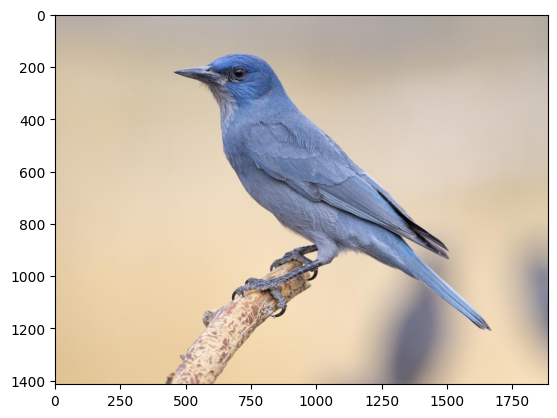

In [4]:
!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png 
img = Image.open('./bird.png') 
plt.imshow(img)
plt.show()

In [5]:
trf = transforms.Compose([transforms.Resize(512),
                 transforms.CenterCrop(512),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

inp = trf(img).unsqueeze(0)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inp = inp.to(device)
model_ft = model_ft.to(device)
out = model_ft(inp)

In [6]:
print(out.shape)

torch.Size([1, 1000])


In [7]:
model_ft.layer4 = NullNet()
model_ft.fc = nn.Linear(256, 10)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
model_ft = model_ft.to(device)
out = model_ft(inp)
print(out)

tensor([[-0.0932,  0.1603,  0.0041,  0.0773, -0.0625, -0.0189,  0.0411,  0.0643,
          0.0659, -0.0119]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Creating Folders

In [9]:
folderlocation = './Data/'
path = folderlocation
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'train/'
if not os.path.exists(path):
    os.mkdir(path)
        
path = folderlocation + 'valid/'
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'test/'
if not os.path.exists(path):
    os.mkdir(path)
    
for iter1 in range(10):    # 10 = number of classes
    path = folderlocation + 'train/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    path = folderlocation + 'valid/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    
    path = folderlocation + 'test/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)

## Download Data and Arrange in Folders

In [10]:
data_train = torchvision.datasets.KMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                             ]))
        
for iter1 in range(len(data_train)):
    x, a = data_train[iter1] 
    if iter1%10 ==0:
        imageio.imwrite(folderlocation + 'valid/'+str(a)+'/valid'+str(iter1)+'.png', x)
    else:
        imageio.imwrite(folderlocation + 'train/'+str(a)+'/train'+str(iter1)+'.png', x)
    
data_test = torchvision.datasets.KMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                             ]))

for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'test/'+str(a)+'/test'+str(iter1)+'.png', x)


100%|██████████| 18165135/18165135 [00:16<00:00, 1083313.29it/s]


Extracting /files/KMNIST/raw/train-images-idx3-ubyte.gz to /files/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 200886.20it/s]


Extracting /files/KMNIST/raw/train-labels-idx1-ubyte.gz to /files/KMNIST/raw



100%|██████████| 3041136/3041136 [00:03<00:00, 988029.80it/s] 


Extracting /files/KMNIST/raw/t10k-images-idx3-ubyte.gz to /files/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 18903905.35it/s]


Extracting /files/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/KMNIST/raw



## KMNIST Data Transformation

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((120,120)),
        transforms.RandomRotation(10,),
        transforms.RandomCrop(112),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    'valid': transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    'test': transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
}

data_dir = folderlocation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


## Data Visualization

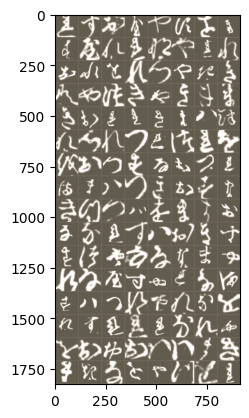

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

## Training function

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training with low lr = 0.01

In [14]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2110 Acc: 0.6798
valid Loss: 0.1667 Acc: 0.9617
test Loss: 0.4594 Acc: 0.8670

Epoch 1/9
----------
train Loss: 0.1404 Acc: 0.9634
valid Loss: 0.0528 Acc: 0.9852
test Loss: 0.1940 Acc: 0.9458

Epoch 2/9
----------
train Loss: 0.0718 Acc: 0.9807
valid Loss: 0.0363 Acc: 0.9912
test Loss: 0.1535 Acc: 0.9579

Epoch 3/9
----------
train Loss: 0.0550 Acc: 0.9845
valid Loss: 0.0482 Acc: 0.9858

Epoch 4/9
----------
train Loss: 0.0433 Acc: 0.9878
valid Loss: 0.0270 Acc: 0.9922
test Loss: 0.1059 Acc: 0.9702

Epoch 5/9
----------
train Loss: 0.0364 Acc: 0.9897
valid Loss: 0.0277 Acc: 0.9920

Epoch 6/9
----------
train Loss: 0.0292 Acc: 0.9920
valid Loss: 0.0195 Acc: 0.9947
test Loss: 0.0807 Acc: 0.9794

Epoch 7/9
----------
train Loss: 0.0196 Acc: 0.9946
valid Loss: 0.0160 Acc: 0.9955
test Loss: 0.0737 Acc: 0.9824

Epoch 8/9
----------
train Loss: 0.0176 Acc: 0.9955
valid Loss: 0.0167 Acc: 0.9953

Epoch 9/9
----------
train Loss: 0.0156 Acc: 0.9962
valid Loss: 

## Training with low lr = 0.001

In [15]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0169 Acc: 0.9959
valid Loss: 0.0161 Acc: 0.9955
test Loss: 0.0734 Acc: 0.9819

Epoch 1/4
----------
train Loss: 0.0159 Acc: 0.9960
valid Loss: 0.0158 Acc: 0.9955

Epoch 2/4
----------
train Loss: 0.0158 Acc: 0.9962
valid Loss: 0.0159 Acc: 0.9957
test Loss: 0.0720 Acc: 0.9818

Epoch 3/4
----------
train Loss: 0.0154 Acc: 0.9960
valid Loss: 0.0160 Acc: 0.9958
test Loss: 0.0704 Acc: 0.9833

Epoch 4/4
----------
train Loss: 0.0144 Acc: 0.9965
valid Loss: 0.0160 Acc: 0.9957

Training complete in 10m 30s
Best val Acc: 0.995833


In [16]:
shutil.rmtree(folderlocation)